<a href="https://colab.research.google.com/github/leticiamchd/Data_Leakage_with_SHAP/blob/main/Data_Leakage_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Data Leakage using SHAP
This notebook stores the code for the article about Detecting Data Leakage using SHAP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Installing SHAP module
!pip install git+https://github.com/slundberg/shap -q


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score,precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb

import shap



In [5]:
# creating a dataframe to the train dataset
df = pd.read_csv("/content/drive/MyDrive/Python Projects/Lenght of Stay Prediction/train.csv")

In [6]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


**All the exploratory data analysis were already done and are detailed into another notebook**

Some changes need to be done before using the dataset into the models:
* Droping the columns `case_id` and `patientid` because they are unique values and doesn't add value for the models
* Do something with the missing values, and in this case, because of the small percentage of that, we'll drop the rows that contains any null values
* Change some columns types
* Change the target `Stay` into a binary value. In this modification, lengh of stay ≤ 30 days will be 0 and > 30 days will be 1
* Create variables dummies for categorical columns


# Pre Processing

## Droping id column

In [7]:
# Checking the size of the dataset before droping the columns
print("This dataset contains" , df.shape[0] , "rows and" , df.shape[1] ,"columns.")

This dataset contains 318438 rows and 18 columns.


In [8]:
# droping the columns case_id and patientid in the same dataset
df.drop(columns=['case_id', 'patientid'], axis = 1, inplace=True)

In [9]:
# Checking the size of the dataset after droping the columns
print("This dataset contains" , df.shape[0] , "rows and" , df.shape[1] ,"columns.")

This dataset contains 318438 rows and 16 columns.


## Missing Values

In [10]:
# Size of the train dataset before removing null values
print("This dataset contains" , df.shape[0] , "rows and" , df.shape[1] ,"columns.")

This dataset contains 318438 rows and 16 columns.


In [11]:
# Checking the amount of null values
df.isnull().sum()

Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

**We can see that only 2 variables have explicity missing values, possibly a small percentage of the dataset considering that there's 318438 rows, but let's check if this perception is true.**

In [12]:
# Checking the percentage of null values 
df.isnull().sum() / df.shape[0] * 100

Hospital_code                        0.000000
Hospital_type_code                   0.000000
City_Code_Hospital                   0.000000
Hospital_region_code                 0.000000
Available Extra Rooms in Hospital    0.000000
Department                           0.000000
Ward_Type                            0.000000
Ward_Facility_Code                   0.000000
Bed Grade                            0.035486
City_Code_Patient                    1.423197
Type of Admission                    0.000000
Severity of Illness                  0.000000
Visitors with Patient                0.000000
Age                                  0.000000
Admission_Deposit                    0.000000
Stay                                 0.000000
dtype: float64

**This confirms the perception about the amount of null values, is a small part of the dataset.**

In [13]:
# Dropping all the rows that contains any null values
df.dropna(axis = 0, inplace=True)

In [14]:
# Checking if there's still null values
df.isnull().sum()

Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

In [15]:
# Checking the shape of the dataset after droping the null values
df.shape

(313793, 16)

**Still a large dataset**

## Changing columns type

In [16]:
# checking the type of each columns of the dataset
df.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [17]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,radiotherapy,R,F,2.0,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,c,5,Z,2,radiotherapy,S,F,2.0,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,10,e,1,X,2,anesthesia,S,E,2.0,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,26,b,2,Y,2,radiotherapy,R,D,2.0,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,26,b,2,Y,2,radiotherapy,S,D,2.0,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


**There are 3 columns as float64 type, and it makes sense when dealing with money as the columns `Admission_Deposit`, but it seems like that the columns `Bed Grade` and `City_Code_Patient` would be better if they were int64 type. Let's check.**

In [18]:
# Checking all unique values for Bed Grade
df['Bed Grade'].unique()

array([2., 3., 4., 1.])

In [19]:
# Checking all unique values for City_Code_Patient
df['City_Code_Patient'].unique()

array([ 7.,  8.,  2.,  5.,  6.,  3.,  4.,  1.,  9., 14., 25., 15., 12.,
       10., 28., 24., 23., 20., 11., 13., 21., 18., 16., 26., 27., 22.,
       19., 31., 34., 32., 30., 29., 37., 33., 35., 36., 38.])

**They both can be int64 type**

In [20]:
# Changing the column "Bed Grade" and "City_Code_Patient" to int type
df["Bed Grade"] = df["Bed Grade"].apply(np.int64)
df["City_Code_Patient"] = df["City_Code_Patient"].apply(np.int64)

In [21]:
# Checking if the type changed
df.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                              int64
City_Code_Patient                      int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [22]:
# Checking if any null values were created with this transformation
df.isnull().sum()

Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

## Target Modification
**The proposal for this model is to predict short Lenght of Stay (LoS) and long LoS. So here we'll separate the Lenght of Stay into 2 categories: ≤ 30 days and > 30 day.**

In [23]:
# Checking the distribution of the target
df["Stay"].value_counts()

21-30                 86316
11-20                 77095
31-40                 54312
51-60                 34463
0-10                  23250
41-50                 11541
71-80                 10096
More than 100 Days     6548
81-90                  4761
91-100                 2713
61-70                  2698
Name: Stay, dtype: int64

In [24]:
# Changing the target into 2 categories: ≤ 30 days and > 30 days
df["Stay"] = df["Stay"].replace(['0-10','11-20', '21-30' ], 0)
df["Stay"] = df["Stay"].replace(['31-40','41-50','51-60',
                                 '61-70', '71-80', '81-90',
                                 '91-100', 'More than 100 Days'], 1)

In [25]:
# Checking the new distribution of the target
df["Stay"].value_counts()

0    186661
1    127132
Name: Stay, dtype: int64

**In this modification, lengh of stay ≤ 30 days will be 0 and > 30 days will be 1**

In [26]:
# Checking if this modification created any null values
df.isnull().sum()

Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

## Create variables dummies for categorical columns

In [27]:
# checking first the categorical columns
df.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                              int64
City_Code_Patient                      int64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                   int64
dtype: object

In [28]:
# Creating the dummies for categorical columns, and droping the original 
df = pd.get_dummies(df, columns= ['Hospital_type_code', 'Hospital_region_code', 'Department',
                                    'Ward_Type', 'Ward_Facility_Code', 'Type of Admission',
                                    'Severity of Illness', 'Age'])

In [29]:
df.head()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,City_Code_Patient,Visitors with Patient,Admission_Deposit,Stay,Hospital_type_code_a,Hospital_type_code_b,...,Age_0-10,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100
0,8,3,3,2,7,2,4911.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,5,2,2,7,2,5954.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,10,1,2,2,7,2,4745.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,26,2,2,2,7,2,7272.0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,26,2,2,2,7,2,5558.0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [30]:
# Checking now the new amount of columns
df.shape

(313793, 51)

In [31]:
# Checking if the transformation created any null values
df.isnull().sum()

Hospital_code                        0
City_Code_Hospital                   0
Available Extra Rooms in Hospital    0
Bed Grade                            0
City_Code_Patient                    0
Visitors with Patient                0
Admission_Deposit                    0
Stay                                 0
Hospital_type_code_a                 0
Hospital_type_code_b                 0
Hospital_type_code_c                 0
Hospital_type_code_d                 0
Hospital_type_code_e                 0
Hospital_type_code_f                 0
Hospital_type_code_g                 0
Hospital_region_code_X               0
Hospital_region_code_Y               0
Hospital_region_code_Z               0
Department_TB & Chest disease        0
Department_anesthesia                0
Department_gynecology                0
Department_radiotherapy              0
Department_surgery                   0
Ward_Type_P                          0
Ward_Type_Q                          0
Ward_Type_R              

In [32]:
# Checking if there is any categorical column
df.dtypes

Hospital_code                          int64
City_Code_Hospital                     int64
Available Extra Rooms in Hospital      int64
Bed Grade                              int64
City_Code_Patient                      int64
Visitors with Patient                  int64
Admission_Deposit                    float64
Stay                                   int64
Hospital_type_code_a                   uint8
Hospital_type_code_b                   uint8
Hospital_type_code_c                   uint8
Hospital_type_code_d                   uint8
Hospital_type_code_e                   uint8
Hospital_type_code_f                   uint8
Hospital_type_code_g                   uint8
Hospital_region_code_X                 uint8
Hospital_region_code_Y                 uint8
Hospital_region_code_Z                 uint8
Department_TB & Chest disease          uint8
Department_anesthesia                  uint8
Department_gynecology                  uint8
Department_radiotherapy                uint8
Department

## Split

In [33]:
# saving the target column into a variable caled y
y = df['Stay']

In [34]:
# droping the target column and saving the rest into a variable caled X
X = df.drop(columns=['Stay'], axis= 1)

In [35]:
y.shape

(313793,)

In [36]:
X.shape

(313793, 50)

**This dataset is already separate into a train and a test datasets, so there is no need to make a train test split. But I'll do this separation for creating a validation set.**

In [37]:
# Spliting into train and test. Only for this dataset, this split wil create a train and a validation datasets.

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=42)

# Training and Evaluating the Performance

In [38]:
%%time
# Random Forest

model_RandomForest = RandomForestClassifier(random_state=42)
model_RandomForest.fit(X_train, y_train)

cross_val_score(model_RandomForest, X_train, y_train,cv=5, scoring='accuracy').mean() 

CPU times: user 4min 52s, sys: 4.2 s, total: 4min 57s
Wall time: 5min 12s


0.7802807599896188

In [39]:
%%time
# Light GBM

model_LightGBM = lgbm.LGBMClassifier(random_state=42)
model_LightGBM.fit(X_train, y_train)

cross_val_score(model_LightGBM, X_train, y_train,cv=5, scoring='accuracy').mean() 

CPU times: user 43.7 s, sys: 556 ms, total: 44.3 s
Wall time: 26.8 s


0.7966251642670523

In [40]:
%%time
# XGBoost

model_XGBoost = xgb.XGBClassifier(random_state=42)
model_XGBoost.fit(X_train, y_train)

cross_val_score(model_XGBoost, X_train, y_train,cv=5, scoring='accuracy').mean() 

CPU times: user 10min 14s, sys: 1.47 s, total: 10min 15s
Wall time: 6min 3s


0.7965096428444289

In [41]:
y_train.value_counts() / y_train.shape[0] * 100

0    59.543727
1    40.456273
Name: Stay, dtype: float64

**When we look into the accuracy of the models with the train set, getting 92% of accuracy for a first glance it souns pretty good, but when we look into our target, they are huge inbalanced (~92.61% of 1 and ~7.39% of 0). So even with a 92% of accuracy, it is possible that the model are just predicting right the targets with value = 1.**

## Confusion Matrix

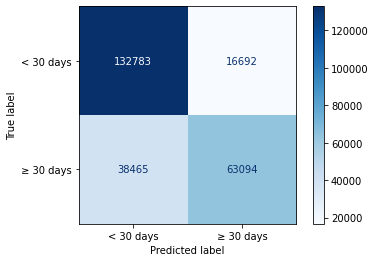

In [42]:
# Random Forest
y_train_pred_RF = cross_val_predict(model_RandomForest,X_train,y_train, cv=5)

cm_crossValidation = confusion_matrix(y_train, y_train_pred_RF) # Confusion Matrix

# Plotting the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_crossValidation, display_labels=['< 30 days', '≥ 30 days'])
disp.plot(cmap='Blues')

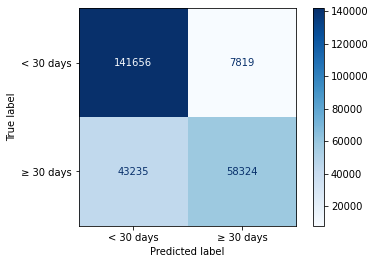

In [43]:
# Light GBM
y_train_pred_LGBM = cross_val_predict(model_LightGBM,X_train,y_train, cv=5)

cm_crossValidation = confusion_matrix(y_train, y_train_pred_LGBM) # Confusion Matrix

# Plotting the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_crossValidation, display_labels=['< 30 days', '≥ 30 days'])
disp.plot(cmap='Blues')

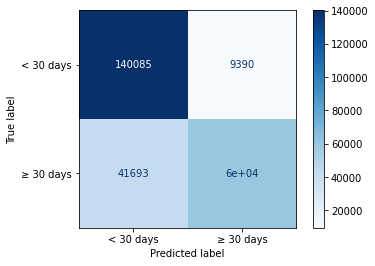

In [44]:
# XGBoost
y_train_pred_XGB = cross_val_predict(model_XGBoost,X_train,y_train, cv=5)

cm_crossValidation = confusion_matrix(y_train, y_train_pred_XGB) # Confusion Matrix

# Plotting the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_crossValidation, display_labels=['< 30 days', '≥ 30 days'])
disp.plot(cmap='Blues')


## Precision, Recall and F1-Score

In [45]:
# Random Forest
print("Precision: {}".format(precision_score(y_train, y_train_pred_RF)))
print("Recall: {}".format(recall_score(y_train, y_train_pred_RF)))
print("F1 Score: {}".format(f1_score(y_train, y_train_pred_RF)))

Precision: 0.7907903642243
Recall: 0.6212546401599071
F1 Score: 0.6958449364471035


In [46]:
# Light GBM
print("Precision: {}".format(precision_score(y_train, y_train_pred_LGBM)))
print("Recall: {}".format(recall_score(y_train, y_train_pred_LGBM)))
print("F1 Score: {}".format(f1_score(y_train, y_train_pred_LGBM)))

Precision: 0.8817864324267118
Recall: 0.5742868677320573
F1 Score: 0.6955671369452958


In [47]:
# XGBoost
print("Precision: {}".format(precision_score(y_train, y_train_pred_XGB)))
print("Recall: {}".format(recall_score(y_train, y_train_pred_XGB)))
print("F1 Score: {}".format(f1_score(y_train, y_train_pred_XGB)))

Precision: 0.8644160794732586
Recall: 0.5894701602024439
F1 Score: 0.700945467318444


## ROC Curve

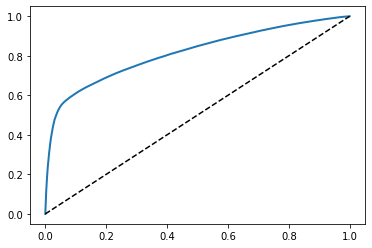

In [48]:
## Random Forest 

y_scores_RF = cross_val_predict(model_RandomForest, X_train, y_train, cv=3, method='predict_proba')[:,1] 

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores_RF)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr,tpr)
plt.show()
     

In [49]:
roc_auc_score(y_train, y_scores_RF)

0.814157042765339

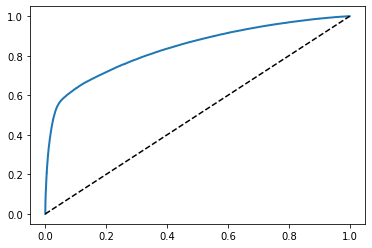

In [50]:
## Light GBM 

y_scores_LGBM = cross_val_predict(model_LightGBM, X_train, y_train, cv=3, method='predict_proba')[:,1] 

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores_LGBM)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr,tpr)
plt.show()
     

In [51]:
roc_auc_score(y_train, y_scores_LGBM)

0.8375027347403766

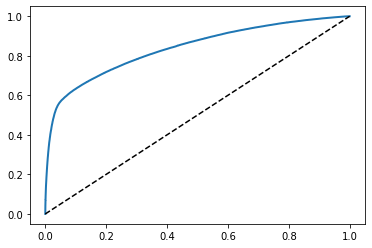

In [52]:
# XGBoost

y_scores_XGB = cross_val_predict(model_XGBoost, X_train, y_train, cv=3, method='predict_proba')[:,1] 

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores_XGB)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr,tpr)
plt.show()


In [53]:
roc_auc_score(y_train, y_scores_XGB)

0.8372468752209913

# Hiperparameters

In [54]:
# Parameters options for testing
parameters = {'learning_rate': [0.005, 0.01],
              'n_estimators': [8, 16, 24],
              'num_leaves': [6, 8, 12, 16]}
              
          
clf = RandomizedSearchCV(model_LightGBM,parameters,n_iter=100,scoring='roc_auc',
                         random_state=42)

clf.fit(X_train, y_train)

The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.


RandomizedSearchCV(estimator=LGBMClassifier(random_state=42), n_iter=100,
                   param_distributions={'learning_rate': [0.005, 0.01],
                                        'n_estimators': [8, 16, 24],
                                        'num_leaves': [6, 8, 12, 16]},
                   random_state=42, scoring='roc_auc')

In [55]:
# Best parameteres
clf.best_params_

{'num_leaves': 16, 'n_estimators': 24, 'learning_rate': 0.01}

In [56]:
%%time
# Light GBM

model_LightGBM = lgbm.LGBMClassifier(random_state=42, num_leaves= 16, n_estimators= 24, learning_rate= 0.01)
model_LightGBM.fit(X_train, y_train)

cross_val_score(model_LightGBM, X_train, y_train,cv=5, scoring='accuracy').mean() 

CPU times: user 15.8 s, sys: 472 ms, total: 16.2 s
Wall time: 11.1 s


0.7833321410552203

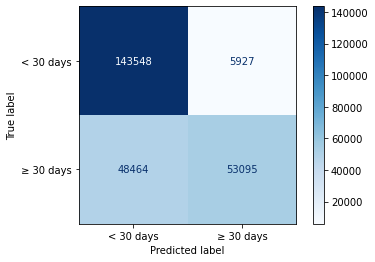

In [57]:
# Light GBM
y_train_pred_LGBM = cross_val_predict(model_LightGBM,X_train,y_train, cv=5)

cm_crossValidation = confusion_matrix(y_train, y_train_pred_LGBM) # Confusion Matrix

# Plotting the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_crossValidation, display_labels=['< 30 days', '≥ 30 days'])
disp.plot(cmap='Blues')

In [58]:
# Light GBM
print("Precision: {}".format(precision_score(y_train, y_train_pred_LGBM)))
print("Recall: {}".format(recall_score(y_train, y_train_pred_LGBM)))
print("F1 Score: {}".format(f1_score(y_train, y_train_pred_LGBM)))

Precision: 0.8995798176950968
Recall: 0.5227995549385086
F1 Score: 0.6612862044700183


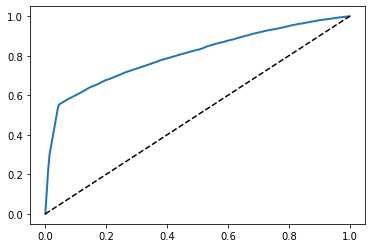

In [59]:
## Light GBM 

y_scores_LGBM = cross_val_predict(model_LightGBM, X_train, y_train, cv=3, method='predict_proba')[:,1] 

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores_LGBM)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr,tpr)
plt.show()
     

In [60]:
roc_auc_score(y_train, y_scores_LGBM)

0.8033835182197285

**The hyper parameters tuning, got the model worst**

# Test
Because of the best performance in the cross validation, the chosen model were LightGBM

In [61]:
# Light GBM

model_LightGBM = lgbm.LGBMClassifier(random_state=42)
model_LightGBM.fit(X_train, y_train)



LGBMClassifier(random_state=42)

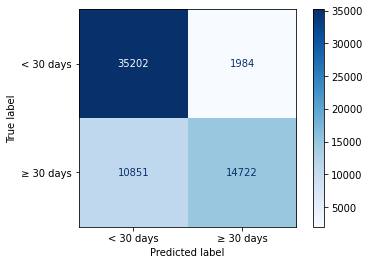

In [62]:
# Light GBM
y_test_pred_LGBM = model_LightGBM.predict(X_test)


cm_crossValidation = confusion_matrix(y_test, y_test_pred_LGBM) # Confusion Matrix

# Plotting the Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_crossValidation, display_labels=['< 30 days', '≥ 30 days'])
disp.plot(cmap='Blues')

In [63]:
# Light GBM
print("Accuracy: {}".format(accuracy_score(y_test,y_test_pred_LGBM)))
print("Precision: {}".format(precision_score(y_test, y_test_pred_LGBM)))
print("Recall: {}".format(recall_score(y_test, y_test_pred_LGBM)))
print("F1 Score: {}".format(f1_score(y_test, y_test_pred_LGBM)))

Accuracy: 0.7954874998008253
Precision: 0.8812402729558243
Recall: 0.575685293082548
F1 Score: 0.696421391234419


In [64]:
roc_auc_score(y_test, y_test_pred_LGBM)

0.7611659402539616

# SHAP

In [65]:
explainer = shap.Explainer(model_LightGBM, X_train)
shap_values = explainer(X_test)

100%|===================| 62723/62759 [06:29<00:00]       

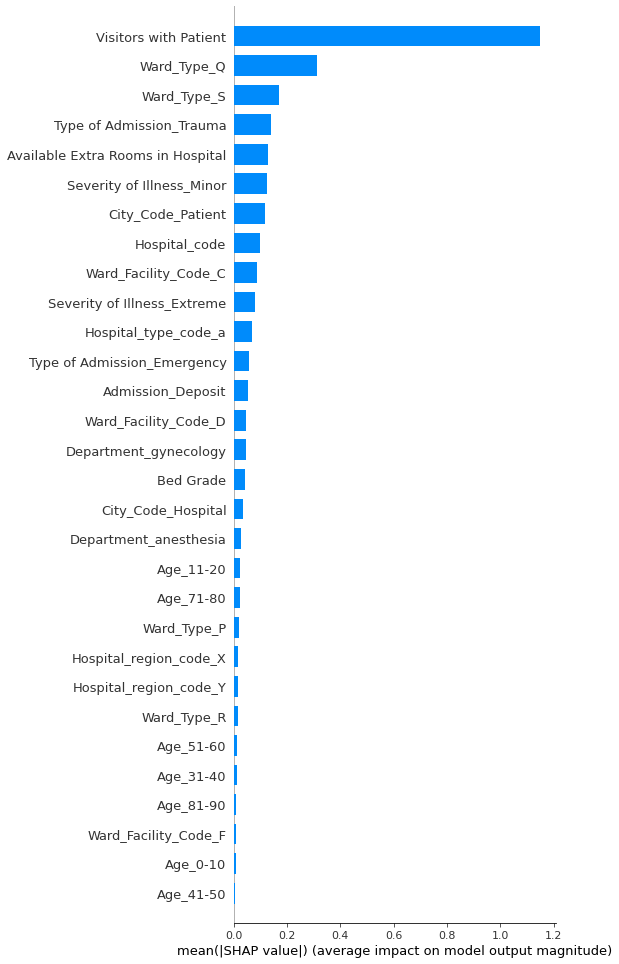

In [66]:
# Ploting the mean absolute SHAP value for each feature regardless the target value
shap.summary_plot(shap_values, plot_type='bar', max_display=30)

* **With SHAP we can see that the variable `Visitors with Patient` had a huge impact on the model output in comparison with all the others features.** 
* **When we think deeper about why this happened, what's the purpose of this prediction, and when this prediction will occur in real word, we get in the conclusion that this was a data leakage.**
* **The goal of this Machine Learning model is to predict long lengh of stay when the patient is admitted into the hospital. At this time is impossible to have the information about how many visitor the patient had, beacuse is a future information.**
* **This could be detected in the beggining, when we are exploring the dataset's features and understanding their meaning. But even if we missed, this can be later detect using SHAP values.**